In [1]:
import pandas as pd

source = "https://sites.math.duke.edu/courses/mth390/data/sortition/"
respondents = pd.read_csv(source + "synthetic_respondents.csv")
respondents.head()

,gender,age,ethnicity,education,employment,covid
0,Male,53.0,Turkish,Higher,Student,Yes
1,Male,37.0,Macedonian,Higher,Unemployed,Yes
2,Female,59.0,Roma,Secondary,Unemployed,Yes
3,Male,46.0,Macedonian,Secondary,Employed,Yes
4,Female,68.0,Albanian,Basic,Student,Yes


In [2]:
categories = pd.read_csv(source + "categories.csv")
categories

,category,name,min,max
0,gender,Male,0,20
1,gender,Female,0,20
2,age,18-25,0,8
3,age,25-35,0,8
4,age,35-45,0,14
5,age,45-55,0,5
6,age,55+,0,5
7,ethnicity,Macedonian,0,23
8,ethnicity,Albanian,0,10
9,ethnicity,Turkish,0,2


In [3]:
import numpy as np

# get the age ranges of respondants associated with the given categories
respondents['age_range'] = ["" for _ in range(len(respondents))]
{(18,24):"18-25", (25,34):"25-35", (35,45):"35-44", (45,55):"45-54", (55,200):"55+"}
for ii in respondents.index:
    age = respondents.loc[ii]['age']
    if age < 25:
        respondents.loc[ii, 'age_range'] = "18-25"
    elif age < 35:
        respondents.loc[ii, 'age_range'] = "25-35"
    elif age < 45:
        respondents.loc[ii, 'age_range'] = "35-45"
    elif age < 55:
        respondents.loc[ii, 'age_range'] = "45-55"
    else:
        respondents.loc[ii, 'age_range'] = "55+"

# infer the population fractions given the maximums of the quotas
category_set = set(list(categories['category']))
category_dict = {}

for cat in category_set:
    data = categories[categories.category == cat]
    value2counts = data[["name", "max"]].set_index("name").to_dict()["max"]
    normalizer = sum(value2counts.values())
    value2counts = {k:v/normalizer for (k,v) in value2counts.items()}
    category_dict[cat] = value2counts

category_dict['age_range'] = category_dict['age']
del category_dict['age']

# look at the disparities between the population and pool
for c in respondents.columns:
    if c == "age":
        continue
    data = respondents[c].value_counts(normalize=True)
    data = data.to_dict()
    # data[["name", "max"]].set_index("name").to_dict()["max"]
    for k in category_dict[c].keys():
        print(c, k, "pop:pool:", category_dict[c][k], ":", data[k])
# 

gender Male pop:pool: 0.5 : 0.5366666666666666
gender Female pop:pool: 0.5 : 0.4633333333333333
ethnicity Macedonian pop:pool: 0.575 : 0.49066666666666664
ethnicity Albanian pop:pool: 0.25 : 0.27666666666666667
ethnicity Turkish pop:pool: 0.05 : 0.034666666666666665
ethnicity Roma pop:pool: 0.025 : 0.06266666666666666
ethnicity Serbian pop:pool: 0.025 : 0.03933333333333333
ethnicity Bosnian pop:pool: 0.025 : 0.034
ethnicity Egyptian pop:pool: 0.025 : 0.04066666666666666
ethnicity Other pop:pool: 0.025 : 0.021333333333333333
education Higher pop:pool: 0.4 : 0.49133333333333334
education Secondary pop:pool: 0.4 : 0.43066666666666664
education Basic pop:pool: 0.2 : 0.078
employment Employed pop:pool: 0.325 : 0.5153333333333333
employment Unemployed pop:pool: 0.475 : 0.37
employment Student pop:pool: 0.2 : 0.11466666666666667
covid Yes pop:pool: 0.4 : 0.7193333333333334
covid No pop:pool: 0.6 : 0.2806666666666667
age_range 18-25 pop:pool: 0.2 : 0.054
age_range 25-35 pop:pool: 0.2 : 0.132
a

In [8]:
import cvxpy as cp
import copy

k = 50 # desired panel size
n = len(respondents)

# variable to optimize over is the probabilty associated with each person
pi = cp.Variable(n)
constraints = [0 <= pi, pi <= 1]

# first make simple constraints that just enforce the probability 
# of seeing k paticipants
simple_constraints = constraints + [cp.sum(pi) == k] 

feature_constraints = copy.copy(simple_constraints)
for c in category_dict:
    for v in category_dict[c]:
        target = k*category_dict[c][v]
        indicator = [1 if p==v else 0 for p in list(respondents[c])]
        feature_constraints += [cp.sum(indicator @ pi) == target]

global_min = [k/n for _ in range(n)]
objective_l1 = cp.Minimize(cp.norm(pi - global_min, 1)**1)
objective_l2 = cp.Minimize(cp.norm(pi - global_min, 2)**2)
# objective_nash = cp.Minimize(-cp.prod(pi)) -- will fail! Try it. Why?
objective_nash_log = cp.Minimize(-cp.sum([cp.log(pi[ii]) for ii in range(n)]))
objective_maximin = cp.Minimize(-cp.min(pi))

prob_l1_simple = cp.Problem(objective_l1, simple_constraints)
prob_l1_feature = cp.Problem(objective_l1, feature_constraints)
prob_l2_simple = cp.Problem(objective_l2, simple_constraints)
prob_l2_feature = cp.Problem(objective_l2, feature_constraints)
prob_nl_simple = cp.Problem(objective_nash_log, simple_constraints)
prob_nl_feature = cp.Problem(objective_nash_log, feature_constraints)
prob_mxmn_simple = cp.Problem(objective_maximin, simple_constraints)
prob_mxmn_feature = cp.Problem(objective_maximin, feature_constraints)

sol_l1_simple = prob_l1_simple.solve(); 
pi_l1_simple = copy.copy(pi.value)

sol_l1_feature = prob_l1_feature.solve(); 
pi_l1_feature = copy.copy(pi.value)

sol_l2_simple = prob_l2_simple.solve(); 
pi_l2_simple = copy.copy(pi.value)

sol_l2_feature = prob_l2_feature.solve(); 
pi_l2_feature = copy.copy(pi.value)

sol_nl_simple = prob_nl_simple.solve(); 
pi_nl_simple = copy.copy(pi.value)

sol_nl_feature = prob_nl_feature.solve(); 
pi_nl_feature = copy.copy(pi.value)

sol_mxmn_simple = prob_mxmn_simple.solve(); 
pi_mxmn_simple = copy.copy(pi.value)

sol_mxmn_feature = prob_mxmn_feature.solve(); 
pi_mxmn_feature = copy.copy(pi.value)

ideal = [k/n for _ in range(n)]

print("check that the simply constrained problems give the correct result")
print("Simply constrained nash error:", np.linalg.norm(ideal - pi_nl_simple)/np.linalg.norm(ideal)) 
print("Simply constrained maximin error:", np.linalg.norm(ideal - pi_mxmn_simple)/np.linalg.norm(ideal)) 
print("Simply constrained l1 error:", np.linalg.norm(ideal - pi_l1_simple)/np.linalg.norm(ideal)) 
print("Simply constrained l1 error:", np.linalg.norm(ideal - pi_l2_simple)/np.linalg.norm(ideal)) 

print("Objective Function Values (simple then feature constrained)")
print("Nash: {}, {}".format(sol_nl_simple, sol_nl_feature))
print("Maximin: {}, {}".format(sol_mxmn_simple, sol_mxmn_feature))
print("l1: {}, {}".format(sol_l1_simple, sol_l1_feature))
print("l2: {}, {}".format(sol_l2_simple, sol_l2_feature))

# "check everything sums to k")
assert k-0.5 < sum(pi_l1_simple) < k+0.5
assert k-0.5 < sum(pi_l1_feature) < k+0.5
assert k-0.5 < sum(pi_l2_simple) < k+0.5
assert k-0.5 < sum(pi_l2_feature) < k+0.5
assert k-0.5 < sum(pi_nl_simple) < k+0.5
assert k-0.5 < sum(pi_nl_feature) < k+0.5
assert k-0.5 < sum(pi_mxmn_simple) < k+0.5
assert k-0.5 < sum(pi_mxmn_feature) < k+0.5

check that the simply constrained problems give the correct result
Simply constrained nash error: 2.862115513574057e-08
Simply constrained maximin error: 1.8943180357666756e-14
Simply constrained l1 error: 2.1857515797307795e-14
Simply constrained l1 error: 7.494005416219816e-15
Objective Function Values (simple then feature constrained)
Nash: 5101.796082870993, 6038.86341687725
Maximin: -0.033333333333333964, -0.009097510837533213
l1: 1.0928757898653885e-12, 37.48170360449815
l2: 9.360019529721966e-29, 3.6772487745852147


/Users/domenicfenoglio/Library/Python/3.9/lib/python/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Matplotlib is building the font cache; this may take a moment.


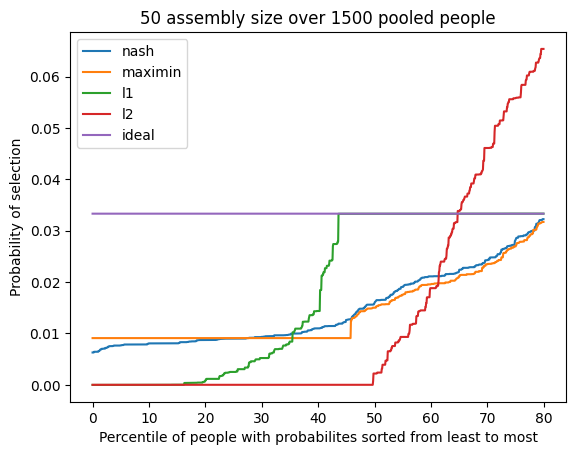

In [10]:
import matplotlib.pyplot as plt

pi_l1_feature.sort()
pi_l2_feature.sort()
pi_mxmn_feature.sort()
pi_nl_feature.sort()

ef = 0.8
x = [ii/n*100 for ii in range(int(ef*n))]
plt.plot(x, pi_nl_feature[:int(n*ef)], label="nash")
plt.plot(x, pi_mxmn_feature[:int(n*ef)], label="maximin")
plt.plot(x, pi_l1_feature[:int(n*ef)], label="l1")
plt.plot(x, pi_l2_feature[:int(n*ef)], label="l2")
plt.plot(x, [k/n for _ in range(int(n*ef))], label="ideal")
plt.xlabel("Percentile of people with probabilites sorted from least to most")
plt.ylabel("Probability of selection")
plt.title("{:} assembly size over {} pooled people".format(k, n))
plt.legend()
plt.show()

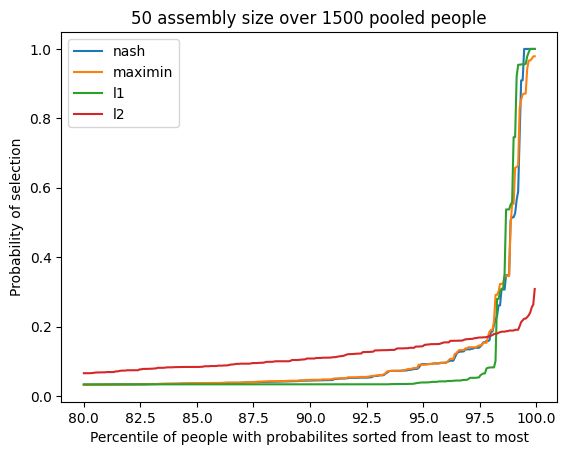

In [11]:
ef = 0.8
x = [ii/n*100 for ii in range(int(ef*n), n)]
plt.plot(x, pi_nl_feature[int(n*ef):n], label="nash")
plt.plot(x, pi_mxmn_feature[int(n*ef):n], label="maximin")
plt.plot(x, pi_l1_feature[int(n*ef):n], label="l1")
plt.plot(x, pi_l2_feature[int(n*ef):n], label="l2")
plt.xlabel("Percentile of people with probabilites sorted from least to most")
plt.ylabel("Probability of selection")
plt.title("{:} assembly size over {} pooled people".format(k, n))
plt.legend()
plt.show()